<a href="https://colab.research.google.com/github/schmidt-marvin/ESI_2022_TecAA/blob/main/KNN_WS2324/nn03/nn03-02-sgd-optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anwendung verschiedener SGD-Varianten in TensorFlow

## (1) Vorwort
Die Ausführungen dieses Code-Beispiels basieren auf dem Inhalt des vorangehenden Notebooks `nn03-01-sgd-minimal.ipynb`, sowie den dort vorgestellten Problemen des Verfahrens. Wie wir gesehen haben, konvergiert das dort trainierte Netz aufgrund mehrerer Probleme eher schlecht, beziehungsweise unkonsistent, größtenteils aufgrund der zu kleinen Netzgröße. Des Weiteren wurde für das Training das "rohe" SGD-Verfahren verwendet.

Um diese Probleme zu beheben, soll in diesem Code-Beispiel sowohl die Größe des Netzes, als auch das Verwendete SGD-Verfahren angepasst werden. Außerdem werden wir die in den TensorFlow-Optimizern bereitgestellte `fit()`-Methode verwenden, anstelle die Funktionalität händisch umzusetzen.

Vorbereitend übernehmen wir den in `nn03-01-sgd-minimal.ipynb` definierten Codeblock zur Erzeugung des Datensatzes, sowie der Visualisierung.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
print(f'TensorFlow version: {tf.__version__}')

keras.backend.clear_session()
print(f'Cleared session cache.')

TensorFlow version: 2.15.0
Cleared session cache.


## (2) Übernehmen der Funktionalität aus `nn03-01-sgd-minimal.ipynb`

In [2]:
# Punktwolke im R^2 mit Labels 0 oder 1
# Kreisförmige Punktewolke (Label 0), umschlossen von anderer Punktewolke (Label 1)
# (Nicht linear separierbar)
def generate_dataset_circular(num_data = 200):
    mean0 = np.transpose([0, 0])
    X0 = mean0 + 0.1*np.random.randn(num_data,2)
    Y0 = np.ones((num_data,2))
    Y0[:,1] = 0*Y0[:,1]


    # points on a circle
    rand_ang=2*np.pi*np.random.random((num_data,1))
    radius=1
    X_ang=radius*(np.concatenate((np.cos(rand_ang),np.sin(rand_ang)),axis=1))

    mean1 = np.transpose([0.0, 0.0])
    X1 = mean1 + 0.1*np.random.randn(num_data,2)
    X1=X1+X_ang
    Y1 = np.ones((num_data,2))
    Y1[:,0] = 0*Y1[:,0]

    X = np.concatenate((X0, X1))
    Y = np.concatenate((Y0, Y1))

    X=X.astype(np.float32)
    Y=Y.astype(np.float32)

    X=np.reshape(X,(2*num_data,2,))

    return X, Y

In [3]:
def visualize_dataset(X, Y, num_data):
  fig, ax = plt.subplots(figsize=(6, 6))

  X_label_0 = X[0:num_data,0], X[0:num_data,1]
  X_label_1 = X[num_data+1:2*num_data,0], X[num_data+1:2*num_data,1]

  ax.scatter(x = X_label_0[0], y = X_label_0[1], c='blue',  label='train class 0', alpha=1)
  ax.scatter(x = X_label_1[0], y = X_label_1[1], c='green', label='train class 1', alpha=1)

  ax.legend(fontsize=20)
  ax.grid(True)

  plt.show()

In [4]:
# Visualisierung der 'decision regions' des Modells
# zur Bewertung des Trainingsprozesses
def plot_decision_regions(model, X, Y, num_data):

    # Dichte Punktewolke innerhalb des Plots
    # (Dargestellt als Datenpunkte mit niedriger Deckkraft)
    num_rand_points = 5000
    # Datenpunkte im Bereich (-1.5, 1.5) - (1.5, -1.5)
    X_regions = 3 * (np.random.random((num_rand_points, 2)) - [0.5, 0.5])

    # Vorhersagung des Modells für alle Elemente der dichten Punktewolke
    Y_regions_pred = (model(X_regions))

    # Indexmenge der vorhergesagten Klassenzugehörigkeiten
    ind_0 = np.where(np.argmax(Y_regions_pred,axis=1) == 0)
    ind_1 = np.where(np.argmax(Y_regions_pred,axis=1) == 1)

    fig, ax = plt.subplots(figsize = (8, 7))

    # Plotting d. dichten Punktewolke
    ax.scatter(X_regions[ind_0, 0], X_regions[ind_0, 1], c='tab:blue',   label='class 0', alpha=0.2, edgecolors='tab:blue')
    ax.scatter(X_regions[ind_1, 0], X_regions[ind_1, 1], c='tab:green',  label='class 1', alpha=0.2, edgecolors='tab:green')

    # -------------------------------------------------

    # Plotting der Trainingsdaten mit korrektem Label
    X_label_0 = X[0:num_data,0],            X[0:num_data,1]
    X_label_1 = X[num_data+1:2*num_data,0], X[num_data+1:2*num_data,1]

    ax.scatter(x = X_label_0[0], y = X_label_0[1], c='blue',  label='train class 0', alpha=1)
    ax.scatter(x = X_label_1[0], y = X_label_1[1], c='green', label='train class 1', alpha=1)

    ax.legend(fontsize=20)
    ax.grid(True)
    plt.show()

X.shape: (400, 2)
X[0]: [-0.04289003  0.10276731]
X[-1]: [-0.92812467  0.25075096]

Y.shape: (400, 2)
Y[0]: [1. 0.]
Y[-1]: [0. 1.]


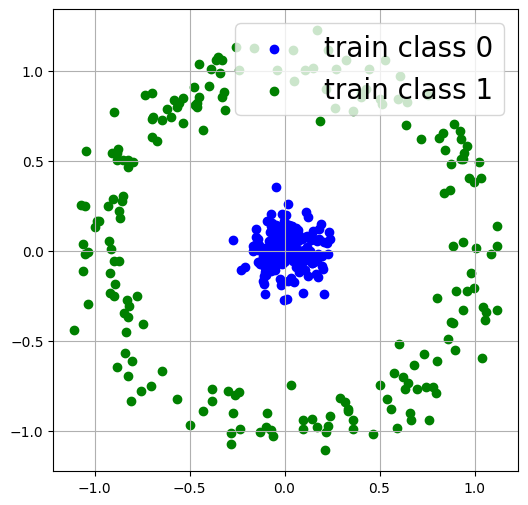

In [5]:
X, Y = generate_dataset_circular(200)

print(f'X.shape: {X.shape}')
print(f'X[0]: {X[0]}')
print(f'X[-1]: {X[-1]}\n')

print(f'Y.shape: {Y.shape}')
print(f'Y[0]: {Y[0]}')
print(f'Y[-1]: {Y[-1]}')

visualize_dataset(X, Y, 200)

## (3) Definition der Netzarchitektur und Wahl der SGD-Variante (Optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 272 (1.06 KB)
Trainable params: 272 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 5s 33ms/step - loss: 0.6662 - accuracy: 0.6531 - val_loss: 0.6302 - val_accuracy: 0.8250
Epoch 2/100
32/3

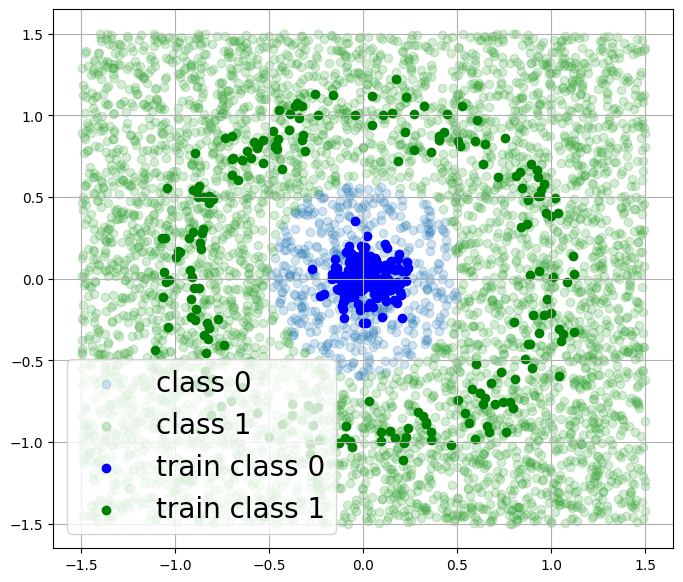

In [6]:
# Netzarchitektur.
# Im Direktvergleich werden deutlich mehr Neuronen pro Layer definiert und
# ein Softmax Encoding als Ausgabe erfordert.

model = keras.Sequential([
    tf.keras.layers.Dense(units = 10, activation='relu',input_shape=(2, )),
    tf.keras.layers.Dense(units = 10, activation='relu'),
    tf.keras.layers.Dense(units = 10, activation='relu'),
    keras.layers.Dense   (units = 2, activation='softmax')
])
model.summary()


# Wahl des Optimizers
# (1) "Standard"-SGD (wie in nn03-01-sgd-minimal)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# (2) SGD mit Momentum
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=False)

# (3) Adam
# ptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


# Festlegung der SGD-Variante, Loss-Metrik und Liste von Metriken 'metrics'.
# Anmerkung: Die Metriken aus 'metrics' fließen *nicht* in den Trainings-
# prozess ein und dienen ausschließlich "Debugging"-Zwecken.
# Sie erlauben der Autorin/dem Autor des Netzes eine Bewertung des
# Trainingsprozesses "durch draufschauen".
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Anstoßen des Trainingsprozesses mittels `fit()`-Methode.
# Die Zuweisung an `model_history` ist nicht zwingend erforderlich und
# dient lediglich den unten erläuterten Visualisierungszwecken.

# Die Anzahl der Update-Schritte bestimmt sich eindeutig über
# die Anzahl der Trainingsdaten, der Batch Size und der Anzahl
# Epochen.

# 400 * 0.8 (Train/Test Split) -> Größe des Trainingsdatensatzes -> 320
# 320 * 10 --> 32 Batches à 10 Datenpunkte --> 32 Update-Schritte pro Epoche
# 32 * 100 --> 100 Epochen à 32 Update-Schritte --> 3200 Update-Schritte.

model_history = model.fit(x = X,
                          y = Y,
                          batch_size = 10,
                          epochs = 100,
                          validation_split = 0.2)


# Visualisierung der Vorhersagen des trainierten Modells
plot_decision_regions(model, X, Y, 200)

## (4) Bewertung des Trainingsverlaufs

Aus der gegebenen Implementierung des `model`-Objektes, in diesem Fall `keras.Sequential` können die während des Trainingsprozesses ausgegebenen Loss-Metriken einfach ausgelesen und visualisiert werden.

Vergleichen Sie die oben definierten Optimizers und insbesondere den Verlauf der Losses.

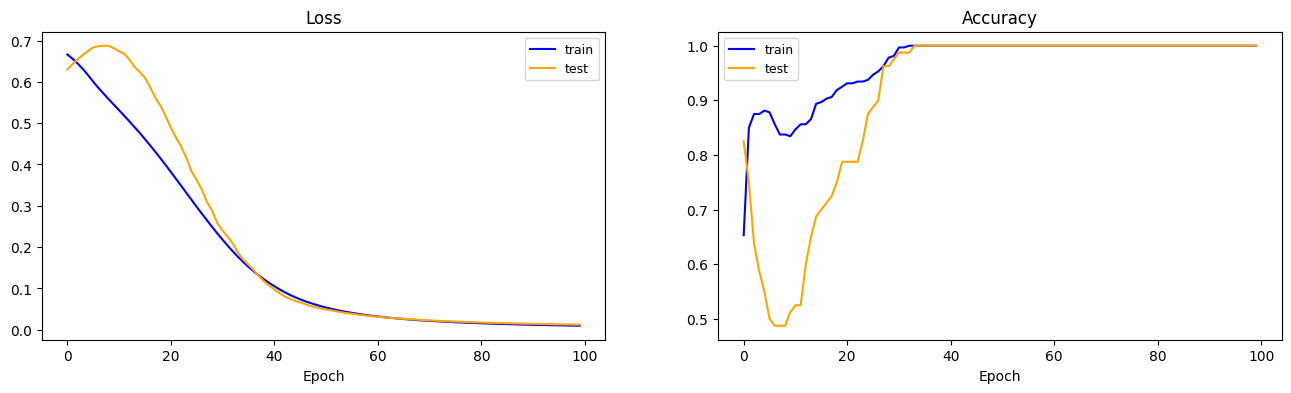

In [7]:
def show_training_progress(history):
    fig, (ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize = (16, 4))

    # Loss-Metrik
    ax1.plot(history.history['loss'], color='blue', label='train')
    ax1.plot(history.history['val_loss'], color='orange', label='test')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(fontsize=9)

    # Bewertungs-Metrik (Accuracy)
    ax2.plot(history.history['accuracy'], color='blue', label='train')
    ax2.plot(history.history['val_accuracy'], color='orange', label='test')

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(fontsize=9)

show_training_progress(model_history)